In [22]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from DS_Planck_Unet import load_planck_model
from DS_healpix_fragmentation import *
from DS_data_transformation import pic2fits
import os
from astropy.coordinates import SkyCoord
from astropy import units as u

In [2]:
pz_model = load_planck_model(
    '/home/rt2122/Models/planck_z/f8d2.ep0014-vl0.006570-l0.004067.hdf5')
act_model = load_planck_model(
    '/home/rt2122/Models/act_cut/act_cut.ep0010-vl0.034219-l0.032022.hdf5')

In [3]:
coords = {'Coma' : [194.9356, 28.0256], 
          'Leo' : [11*15+44/4, 19+45/60], 
          'A399' : [2*15+57/4, 13+2/60], 
          'Shapley' : [13*15+25/4, -30]}
coords

{'Coma': [194.9356, 28.0256],
 'Leo': [176.0, 19.75],
 'A399': [44.25, 13.033333333333333],
 'Shapley': [201.25, -30]}

In [12]:
matrs = {}
for key in coords:
    big_nside, big_pix = find_biggest_pixel(*coords[key], 900/60)
    print(big_nside)
    matr = one_pixel_fragmentation(big_nside, big_pix, 
                                   int(np.log2(2**11 / big_nside)))
    mdict = matr2dict(matr)
    x, y = mdict[radec2pix(*coords[key], 2**11)]
    matr = matr[max(0, x-60):min(x+60, matr.shape[0]-1), 
                max(y-60, 0):min(y+60, matr.shape[1] - 1)]
    matrs[key] = matr

2
2
2
2


In [5]:
def gen_scan_by_matr(matr, model, step=8, size=64):
    import numpy as np
    from DS_Planck_Unet import draw_pic
    from DS_data_transformation import normalize
    
    mask = np.zeros(list(matr.shape) + [1], dtype=np.float64)
    divider = np.zeros(list(matr.shape) + [1], dtype=np.float64)
    pic = normalize(draw_pic(matr))
    ypic = normalize(draw_pic(matr, y=True))
    
    st = []
    for k in range(2):
        x_st = [i for i in range(0, matr.shape[k], step) 
                if i + size <= matr.shape[k]] + [matr.shape[k] - size]
        last = matr.shape[k] - size
        if x_st[-1] != last:
            x_st.append(last)
        st.append(x_st)
    
    for x in st[0]:
        for y in st[1]:
            ans = model.predict(np.array([pic[x:x+64, y:y+64]]))[0]
            mask[x:x+64, y:y+64] += ans 
            divider[x:x+64, y:y+64] += 1
    return np.dstack([pic, ypic, normalize(mask / divider)])

In [13]:
pics = {}
for key in matrs:
    pic = gen_scan_by_matr(matrs[key], pz_model)
    pics[key] = pic

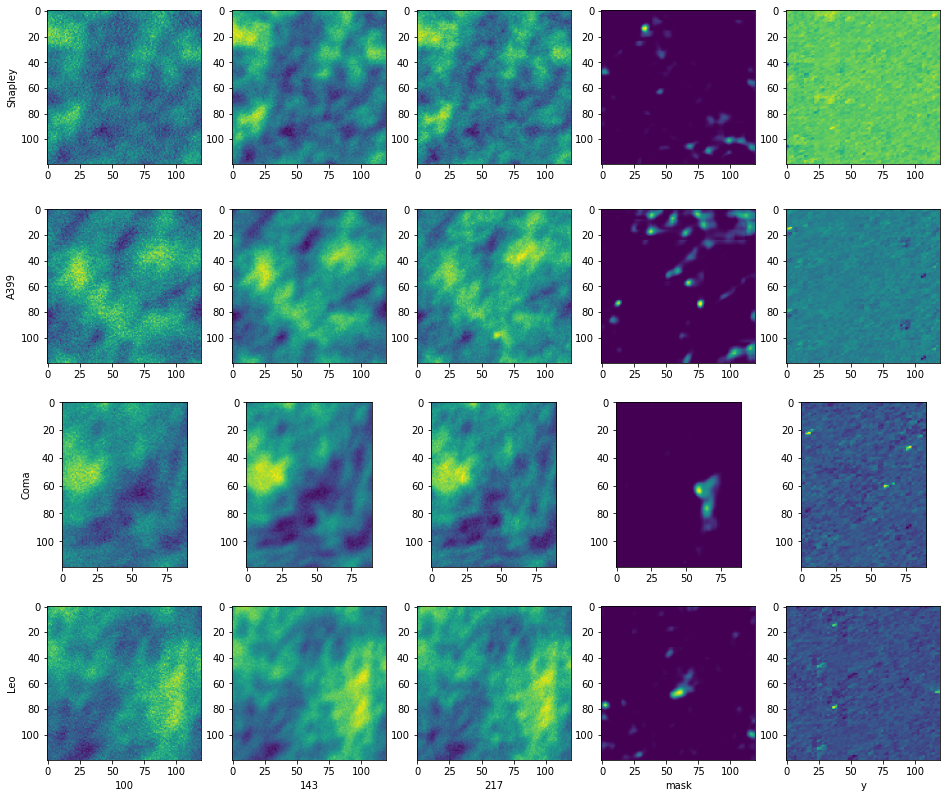

In [14]:
_, ax = plt.subplots(4, 5, figsize=(16, 14))
for i, key in enumerate(['Shapley', 'A399', 'Coma', 'Leo']):
    ax[i][0].set_ylabel(key)
    ax[i][0].imshow(pics[key][:,:,0]) 
    ax[i][1].imshow(pics[key][:,:,1]) 
    ax[i][2].imshow(pics[key][:,:,2]) 
    ax[i][3].imshow(pics[key][:,:,7]) #mask
    ax[i][4].imshow(pics[key][:,:,6]) #ypic
    if key == 'Leo':
        ax[i][0].set_xlabel('100')
        ax[i][1].set_xlabel('143')
        ax[i][2].set_xlabel('217')
        ax[i][3].set_xlabel('mask')
        ax[i][4].set_xlabel('y')

In [20]:
for key in pics:
    pic2fits(pics[key], None, os.path.join('/home/rt2122/Data/cur/4pics', key + '.fits'))

In [21]:
df_pz_act = pd.read_csv(
    '/home/rt2122/Data/scans_old/scans_extended/connected/full_act_cut_ep14_thr0.1_step8.csv')
df_pz = pd.read_csv('/home/rt2122/Data/scans_old/scans_extended/connected/ep14_thr0.1_step8_nofn.csv')

In [29]:
pz_sc = SkyCoord(ra=np.array(df_pz['RA'])*u.degree, 
                 dec=np.array(df_pz['DEC'])*u.degree, frame='icrs')
pz_act_sc = SkyCoord(ra=np.array(df_pz_act['RA'])*u.degree, 
                 dec=np.array(df_pz_act['DEC'])*u.degree, frame='icrs')
thr_list = (2.5/60, 5/60, 10/60)
print('Совпадения с каталогами на расстояниях', [60 * k for k in thr_list], 'минут')
for key in coords:
    sc = SkyCoord(ra=coords[key][0]*u.degree, dec=coords[key][1]*u.degree, frame='icrs')
    print(key)
    dist = sc.separation(pz_sc).degree
    print('pz    ', [np.count_nonzero(dist < thr) for thr in thr_list])
    dist = sc.separation(pz_act_sc).degree
    print('pz_act', [np.count_nonzero(dist < thr) for thr in thr_list])

Совпадения с каталогами на расстояниях [2.5, 5.0, 10.0] минут
Coma
pz     [0, 0, 0]
pz_act [0, 0, 1]
Leo
pz     [0, 0, 1]
pz_act [0, 1, 1]
A399
pz     [0, 0, 1]
pz_act [0, 0, 0]
Shapley
pz     [0, 0, 0]
pz_act [0, 0, 0]
